In [1]:
import torch as tch
import torch.nn.functional as F
import torch.nn as tchnn
import torch.autograd as tchagd
import torch.optim as tchoptim
from torch.autograd import Variable
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import random
import visdom

In [2]:
#params for the system
e_inp_dim = 28*28
e_out_dim = 100 #z, latent variable
d_inp_dim = 100
d_out_dim = 28*28
n_hidden = 512
BATCHSZ = 64*2

In [3]:
#visdom client
vis = visdom.Visdom(port=7777)

In [3]:
#encoder network (X -> z)
class Encoder(tchnn.Module):
	def __init__(self):
		super(Encoder, self).__init__()
		self.L1 = tchnn.Linear(e_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, e_out_dim) #for mu and sigma 
		self.L3 = tchnn.Linear(e_out_dim, e_out_dim)#for mu
		self.L4 = tchnn.Linear(e_out_dim, e_out_dim)#for sigma
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.relu(self.Ou(x))
		#mu = x[:, :e_out_dim]
		#sig = x[:, e_out_dim:]
		mu = self.L3(x)
		sig = self.L4(x)
		#need to make sure that sigmas are positive
		#sig = F.softplus(sig)
		return mu, sig
		
	def name(self):
		return 'Encoder'

In [4]:
class Decoder(tchnn.Module):
	def __init__(self):
		super(Decoder, self).__init__()
		self.L1 = tchnn.Linear(d_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, d_out_dim)
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.sigmoid(self.Ou(x))
		return x
	
	def name(self):
		return 'Decoder'

In [5]:
#xavier weight initialisation, suggested to be good
def wt_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        my_xavier(m.weight.data.cpu())
        m.bias.data.fill_(0) #make it all zero, see the scripts

In [6]:
def my_xavier(W):
    size = W.size()
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(tch.randn(*size) * xavier_stddev, requires_grad=True).cuda()

In [7]:
#data loading and related stuff
MNISTX_train = np.load('../data/MNIST/3/3.npy')
#corrupting 20% of the data
num_samples = MNISTX_train.shape[0]
num_corrupt = int(0.2*num_samples)
indx = np.arange(num_samples)
indxl = list(indx)
zoob = random.sample(indxl, num_corrupt)
noise_for_corruption = np.random.randn(num_corrupt, MNISTX_train.shape[1])*12
MNISTX_train[zoob, :] += noise_for_corruption
MNISTX_train -= np.min(MNISTX_train)
MNISTX_train /= np.max(MNISTX_train)

def MNIST_gen(X, BATCHSZ):
    X = X.reshape(-1,784) #serialize images
    while(True):
        databatch = random.sample(list(X), BATCHSZ)
        databatch = np.array(databatch)
        yield databatch

MNISTd = MNIST_gen(MNISTX_train, BATCHSZ)

In [10]:
print(next(MNISTd)[0,:])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

In [8]:
#mnist batch plotter
def plotter(batch_data):
    #batch_data = batch_data.numpy()
    n = batch_data.shape[0]
    for i in range(n):
        plt.subplot(8,8,i+1)
        plt.imshow(batch_data[i].reshape(-1,28), cmap='gray', interpolation='none')
        plt.axis('off')
    plt.show()

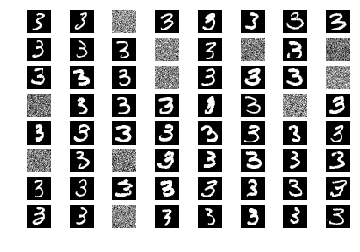

In [9]:
plotter(next(MNISTd)[0:64])

In [10]:
#pretraining
E = Encoder().cuda()
D = Decoder().cuda()
E = E.double()
D = D.double()
E.apply(wt_init)
D.apply(wt_init)
print(E)
print(D)

Encoder(
  (L1): Linear(in_features=784, out_features=512)
  (Ou): Linear(in_features=512, out_features=100)
  (L3): Linear(in_features=100, out_features=100)
  (L4): Linear(in_features=100, out_features=100)
)
Decoder(
  (L1): Linear(in_features=100, out_features=512)
  (Ou): Linear(in_features=512, out_features=784)
)


In [11]:
optim = tchoptim.Adam(list(E.parameters())+ list(D.parameters()), lr=1e-3)

In [12]:
def sample_z(mu, sig):
    e = Variable(tch.randn(BATCHSZ, e_out_dim).cuda().double())
    r = mu + (e*tch.exp(sig/2))
    return r
    

In [13]:
def my_L1_eps_loss(inp, target, eps=0.1, q=2):
    loss1 = tchnn.L1Loss(reduce=False)
    a = loss1(inp, target)
    a = a+eps
    a = tch.pow(a,2)
    b = tch.sum(a,dim=1)
    b = tch.pow(b,q/2)
    c = tch.sum(b)
    c = c/(inp.size()[0]*inp.size()[1])
    return c

In [14]:
n_epoch = 100
n_iter = 100
n_generated_samples = 1000

====> Epoch: 0 Average loss: 0.0075
########### generating samples after epoch 0 ###########


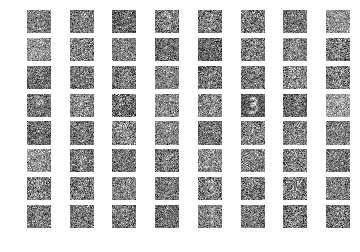

====> Epoch: 1 Average loss: 0.0074
########### generating samples after epoch 1 ###########


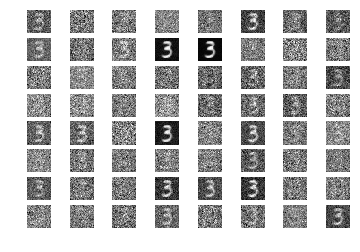

====> Epoch: 2 Average loss: 0.0073
########### generating samples after epoch 2 ###########


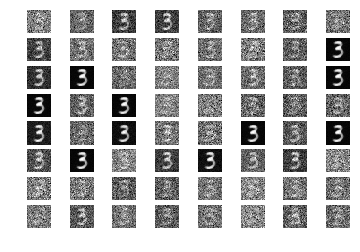

====> Epoch: 3 Average loss: 0.0073
########### generating samples after epoch 3 ###########


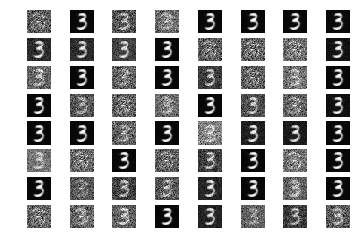

====> Epoch: 4 Average loss: 0.0073
########### generating samples after epoch 4 ###########


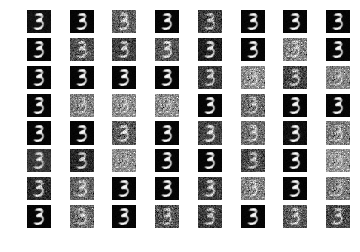

====> Epoch: 5 Average loss: 0.0073
########### generating samples after epoch 5 ###########


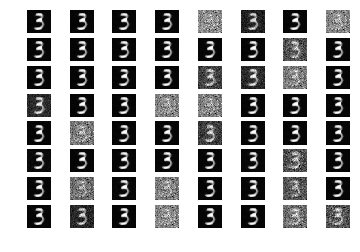

====> Epoch: 6 Average loss: 0.0073
########### generating samples after epoch 6 ###########


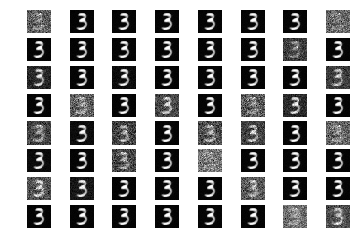

====> Epoch: 7 Average loss: 0.0073
########### generating samples after epoch 7 ###########


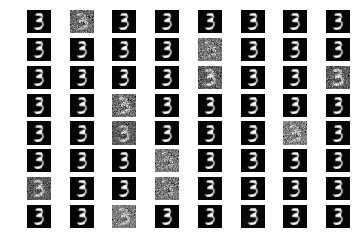

====> Epoch: 8 Average loss: 0.0073
########### generating samples after epoch 8 ###########


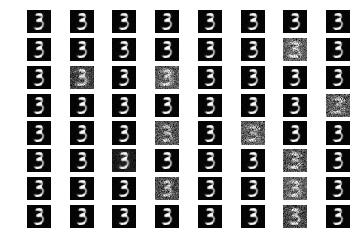

====> Epoch: 9 Average loss: 0.0073
########### generating samples after epoch 9 ###########


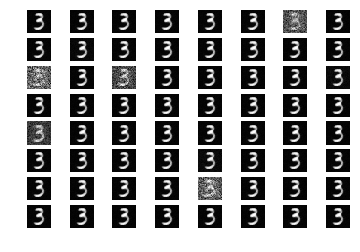

====> Epoch: 10 Average loss: 0.0073
########### generating samples after epoch 10 ###########


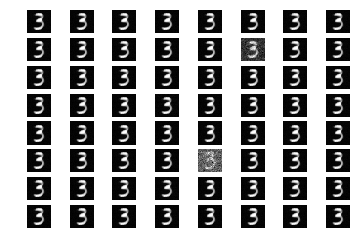

====> Epoch: 11 Average loss: 0.0073
########### generating samples after epoch 11 ###########


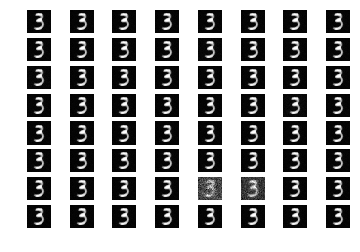

====> Epoch: 12 Average loss: 0.0073
########### generating samples after epoch 12 ###########


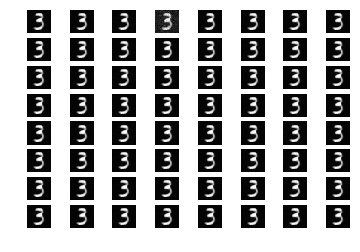

====> Epoch: 13 Average loss: 0.0073
########### generating samples after epoch 13 ###########


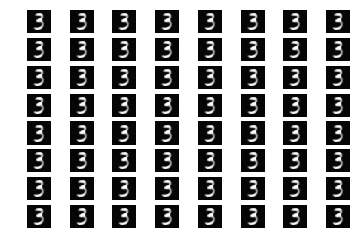

====> Epoch: 14 Average loss: 0.0073
########### generating samples after epoch 14 ###########


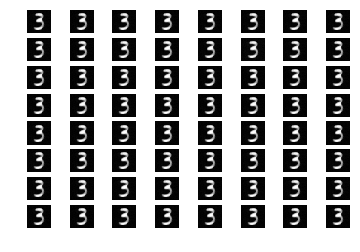

====> Epoch: 15 Average loss: 0.0073
########### generating samples after epoch 15 ###########


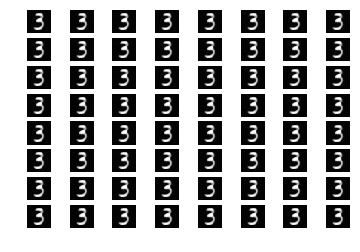

====> Epoch: 16 Average loss: 0.0073
########### generating samples after epoch 16 ###########


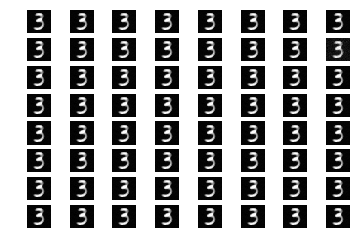

====> Epoch: 17 Average loss: 0.0073
########### generating samples after epoch 17 ###########


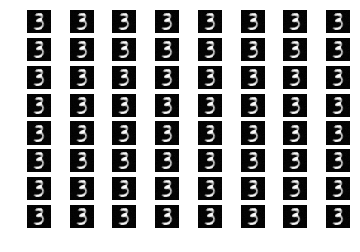

====> Epoch: 18 Average loss: 0.0073
########### generating samples after epoch 18 ###########


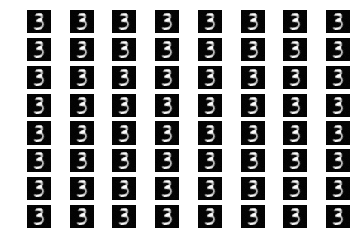

====> Epoch: 19 Average loss: 0.0073
########### generating samples after epoch 19 ###########


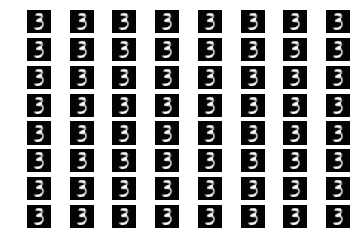

====> Epoch: 20 Average loss: 0.0073
########### generating samples after epoch 20 ###########


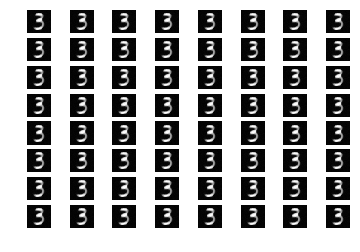

====> Epoch: 21 Average loss: 0.0073
########### generating samples after epoch 21 ###########


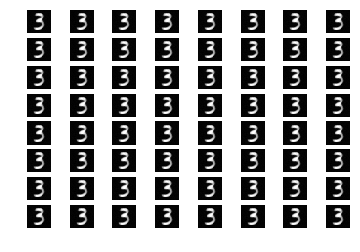

====> Epoch: 22 Average loss: 0.0073
########### generating samples after epoch 22 ###########


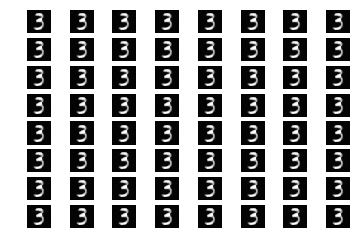

====> Epoch: 23 Average loss: 0.0073
########### generating samples after epoch 23 ###########


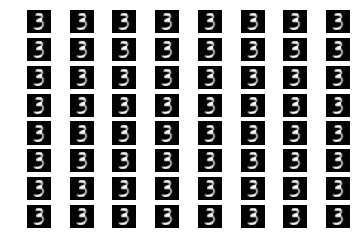

====> Epoch: 24 Average loss: 0.0073
########### generating samples after epoch 24 ###########


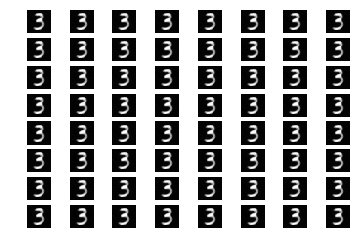

====> Epoch: 25 Average loss: 0.0073
########### generating samples after epoch 25 ###########


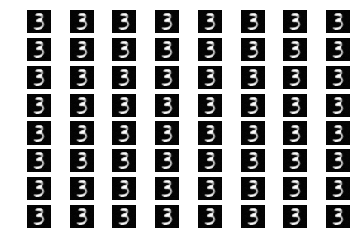

====> Epoch: 26 Average loss: 0.0073
########### generating samples after epoch 26 ###########


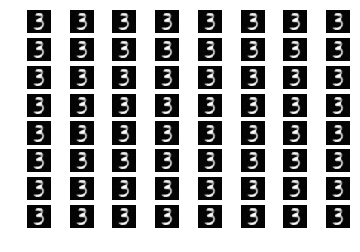

====> Epoch: 27 Average loss: 0.0073
########### generating samples after epoch 27 ###########


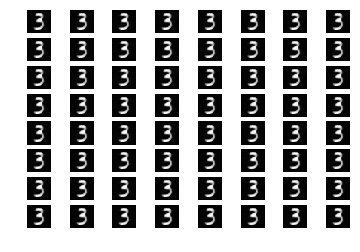

====> Epoch: 28 Average loss: 0.0073
########### generating samples after epoch 28 ###########


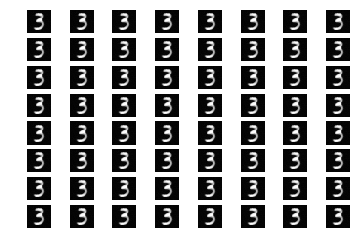

====> Epoch: 29 Average loss: 0.0073
########### generating samples after epoch 29 ###########


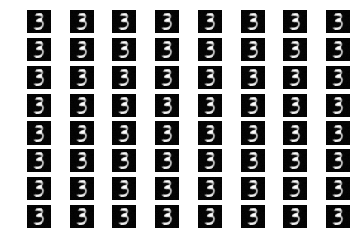

====> Epoch: 30 Average loss: 0.0073
########### generating samples after epoch 30 ###########


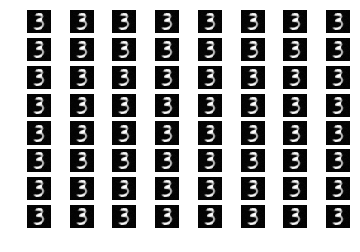

====> Epoch: 31 Average loss: 0.0073
########### generating samples after epoch 31 ###########


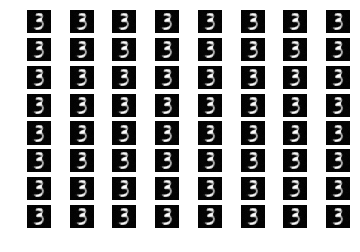

====> Epoch: 32 Average loss: 0.0073
########### generating samples after epoch 32 ###########


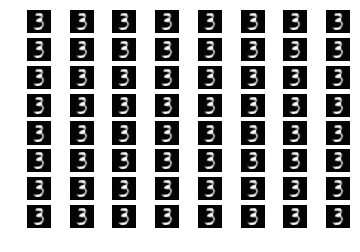

====> Epoch: 33 Average loss: 0.0073
########### generating samples after epoch 33 ###########


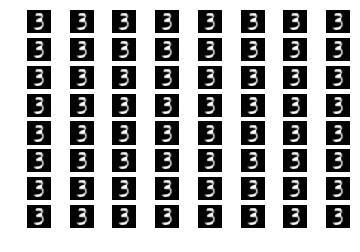

====> Epoch: 34 Average loss: 0.0073
########### generating samples after epoch 34 ###########


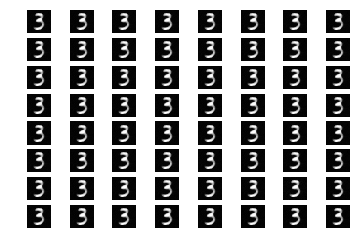

====> Epoch: 35 Average loss: 0.0073
########### generating samples after epoch 35 ###########


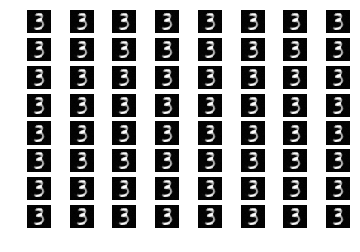

====> Epoch: 36 Average loss: 0.0073
########### generating samples after epoch 36 ###########


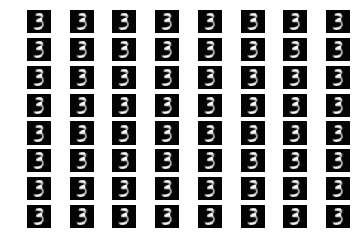

====> Epoch: 37 Average loss: 0.0073
########### generating samples after epoch 37 ###########


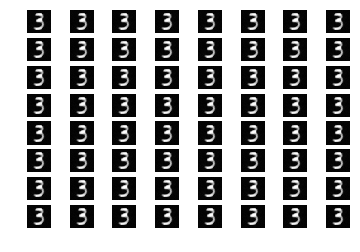

====> Epoch: 38 Average loss: 0.0073
########### generating samples after epoch 38 ###########


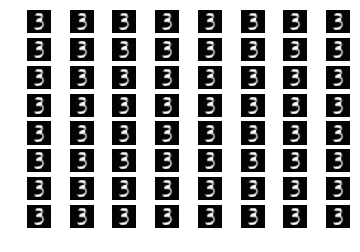

====> Epoch: 39 Average loss: 0.0073
########### generating samples after epoch 39 ###########


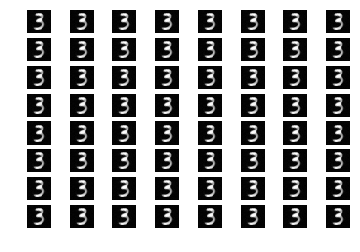

====> Epoch: 40 Average loss: 0.0073
########### generating samples after epoch 40 ###########


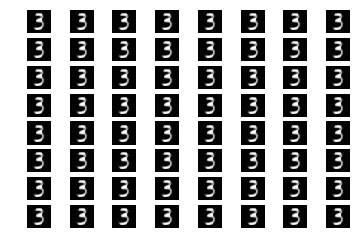

====> Epoch: 41 Average loss: 0.0073
########### generating samples after epoch 41 ###########


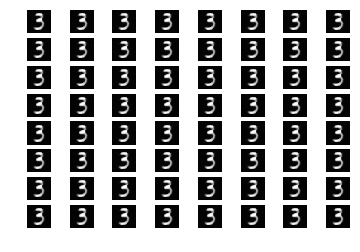

====> Epoch: 42 Average loss: 0.0073
########### generating samples after epoch 42 ###########


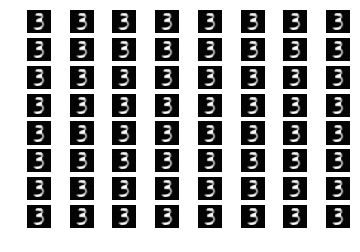

====> Epoch: 43 Average loss: 0.0073
########### generating samples after epoch 43 ###########


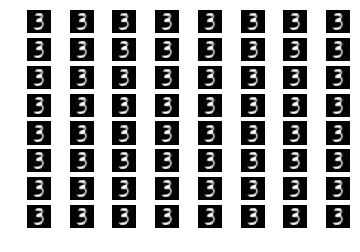

====> Epoch: 44 Average loss: 0.0073
########### generating samples after epoch 44 ###########


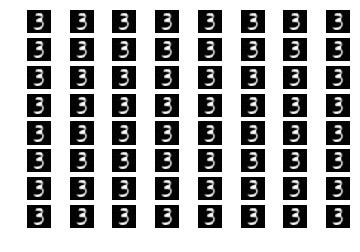

====> Epoch: 45 Average loss: 0.0073
########### generating samples after epoch 45 ###########


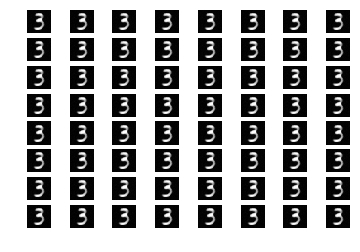

====> Epoch: 46 Average loss: 0.0073
########### generating samples after epoch 46 ###########


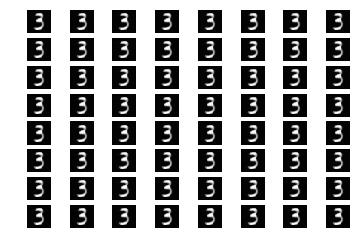

====> Epoch: 47 Average loss: 0.0073
########### generating samples after epoch 47 ###########


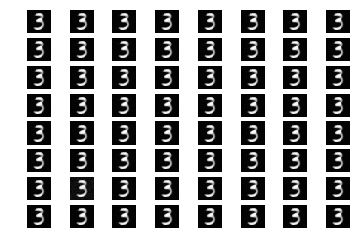

====> Epoch: 48 Average loss: 0.0073
########### generating samples after epoch 48 ###########


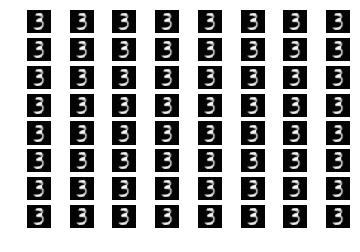

====> Epoch: 49 Average loss: 0.0073
########### generating samples after epoch 49 ###########


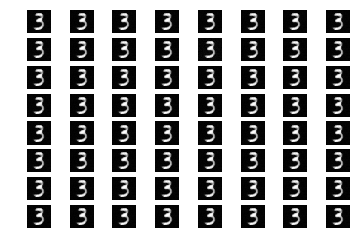

====> Epoch: 50 Average loss: 0.0073
########### generating samples after epoch 50 ###########


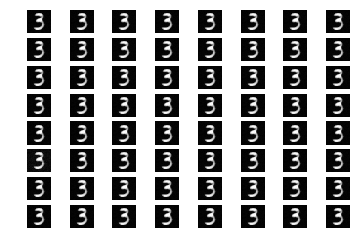

====> Epoch: 51 Average loss: 0.0073
########### generating samples after epoch 51 ###########


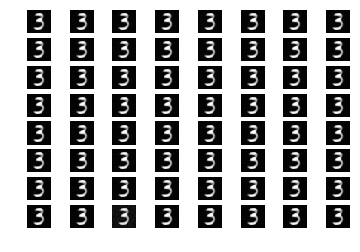

====> Epoch: 52 Average loss: 0.0073
########### generating samples after epoch 52 ###########


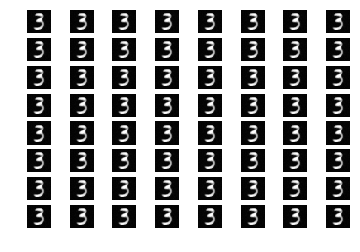

====> Epoch: 53 Average loss: 0.0073
########### generating samples after epoch 53 ###########


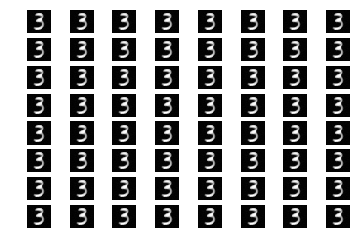

====> Epoch: 54 Average loss: 0.0073
########### generating samples after epoch 54 ###########


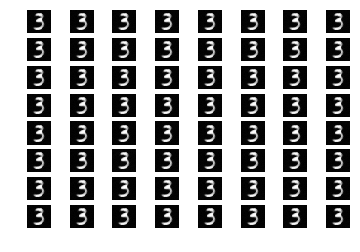

====> Epoch: 55 Average loss: 0.0073
########### generating samples after epoch 55 ###########


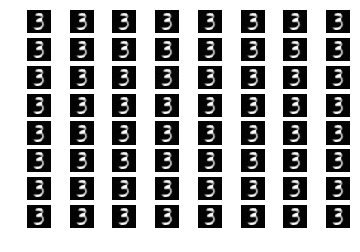

====> Epoch: 56 Average loss: 0.0073
########### generating samples after epoch 56 ###########


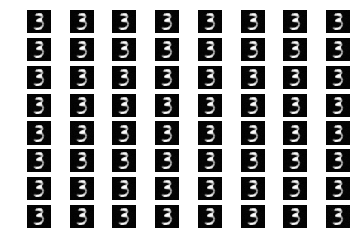

====> Epoch: 57 Average loss: 0.0073
########### generating samples after epoch 57 ###########


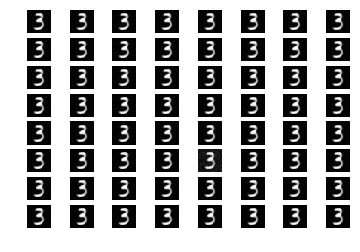

====> Epoch: 58 Average loss: 0.0073
########### generating samples after epoch 58 ###########


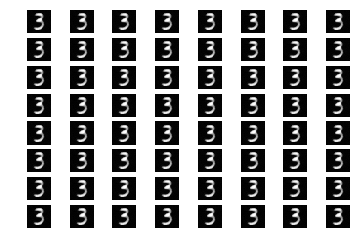

====> Epoch: 59 Average loss: 0.0073
########### generating samples after epoch 59 ###########


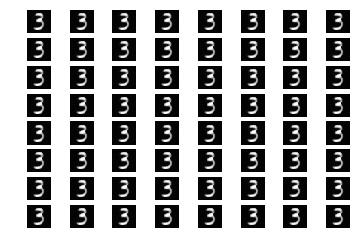

====> Epoch: 60 Average loss: 0.0073
########### generating samples after epoch 60 ###########


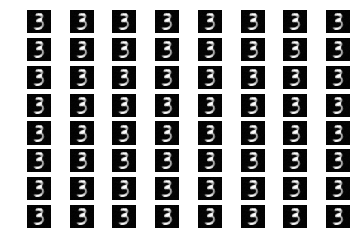

====> Epoch: 61 Average loss: 0.0073
########### generating samples after epoch 61 ###########


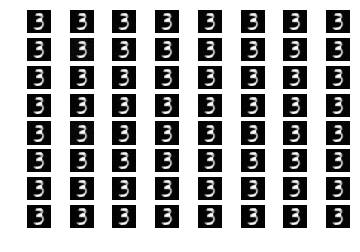

====> Epoch: 62 Average loss: 0.0073
########### generating samples after epoch 62 ###########


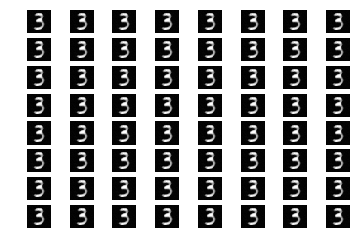

====> Epoch: 63 Average loss: 0.0073
########### generating samples after epoch 63 ###########


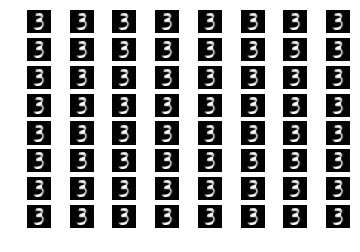

====> Epoch: 64 Average loss: 0.0073
########### generating samples after epoch 64 ###########


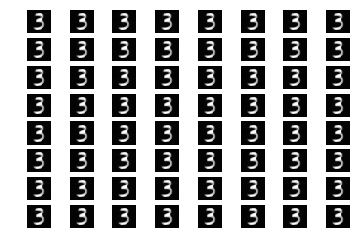

====> Epoch: 65 Average loss: 0.0073
########### generating samples after epoch 65 ###########


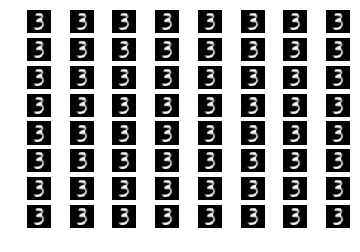

====> Epoch: 66 Average loss: 0.0073
########### generating samples after epoch 66 ###########


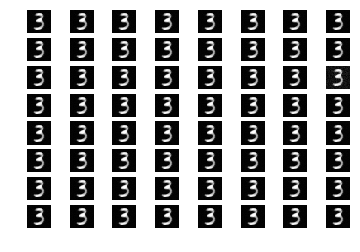

====> Epoch: 67 Average loss: 0.0073
########### generating samples after epoch 67 ###########


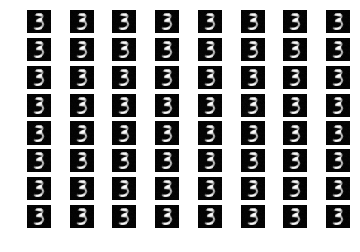

====> Epoch: 68 Average loss: 0.0073
########### generating samples after epoch 68 ###########


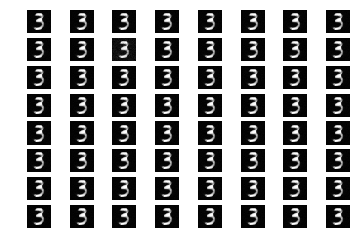

====> Epoch: 69 Average loss: 0.0073
########### generating samples after epoch 69 ###########


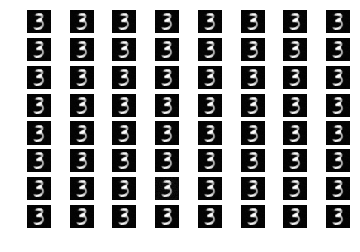

====> Epoch: 70 Average loss: 0.0073
########### generating samples after epoch 70 ###########


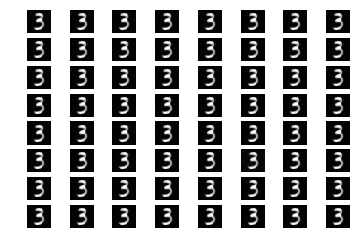

====> Epoch: 71 Average loss: 0.0073
########### generating samples after epoch 71 ###########


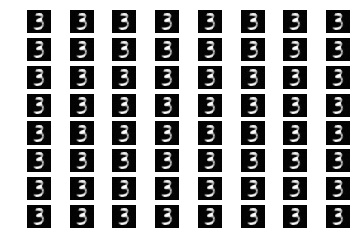

====> Epoch: 72 Average loss: 0.0073
########### generating samples after epoch 72 ###########


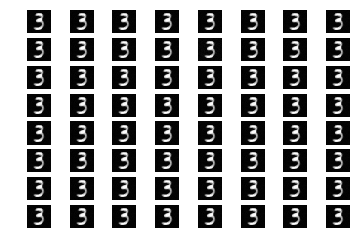

====> Epoch: 73 Average loss: 0.0073
########### generating samples after epoch 73 ###########


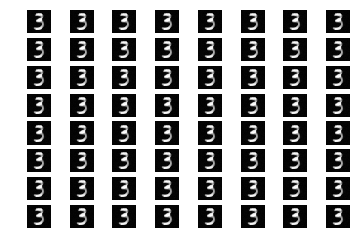

====> Epoch: 74 Average loss: 0.0073
########### generating samples after epoch 74 ###########


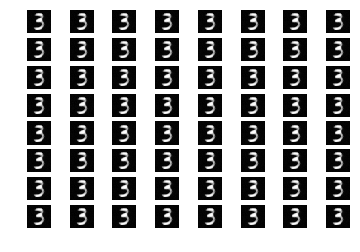

====> Epoch: 75 Average loss: 0.0073
########### generating samples after epoch 75 ###########


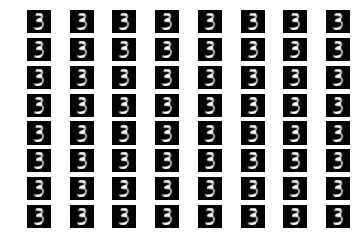

====> Epoch: 76 Average loss: 0.0073
########### generating samples after epoch 76 ###########


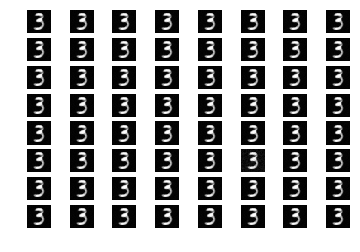

====> Epoch: 77 Average loss: 0.0073
########### generating samples after epoch 77 ###########


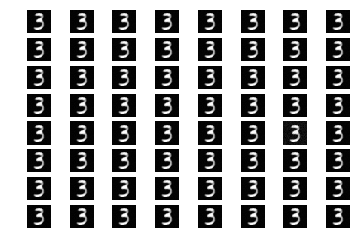

====> Epoch: 78 Average loss: 0.0073
########### generating samples after epoch 78 ###########


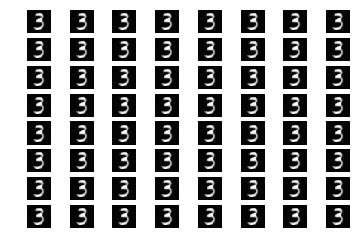

====> Epoch: 79 Average loss: 0.0073
########### generating samples after epoch 79 ###########


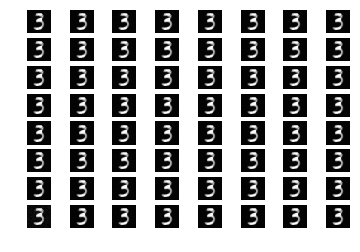

====> Epoch: 80 Average loss: 0.0073
########### generating samples after epoch 80 ###########


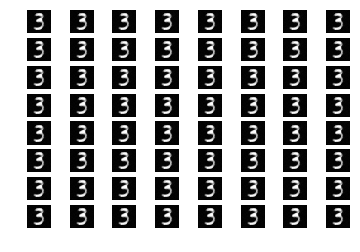

====> Epoch: 81 Average loss: 0.0073
########### generating samples after epoch 81 ###########


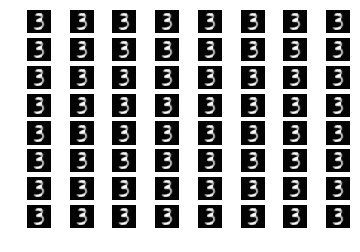

====> Epoch: 82 Average loss: 0.0073
########### generating samples after epoch 82 ###########


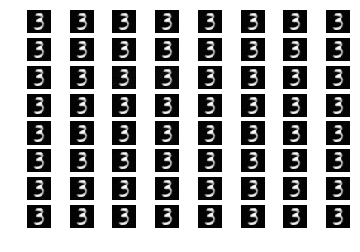

====> Epoch: 83 Average loss: 0.0073
########### generating samples after epoch 83 ###########


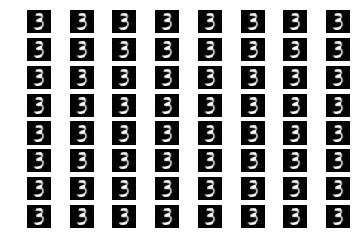

====> Epoch: 84 Average loss: 0.0073
########### generating samples after epoch 84 ###########


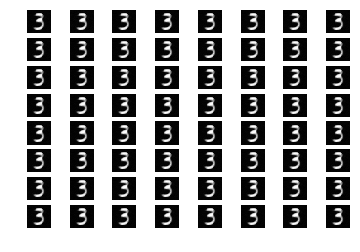

====> Epoch: 85 Average loss: 0.0073
########### generating samples after epoch 85 ###########


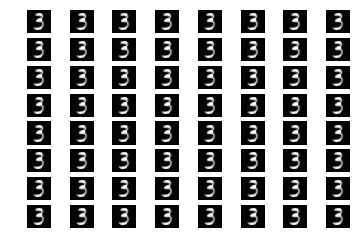

====> Epoch: 86 Average loss: 0.0073
########### generating samples after epoch 86 ###########


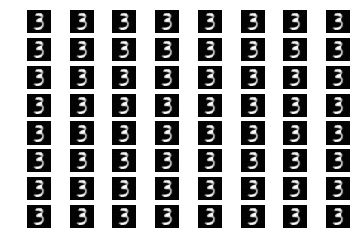

====> Epoch: 87 Average loss: 0.0073
########### generating samples after epoch 87 ###########


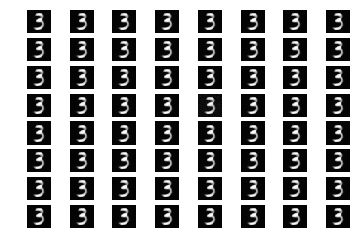

====> Epoch: 88 Average loss: 0.0073
########### generating samples after epoch 88 ###########


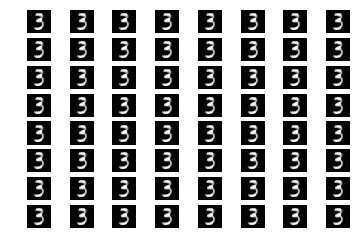

====> Epoch: 89 Average loss: 0.0073
########### generating samples after epoch 89 ###########


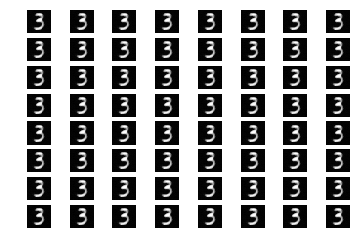

====> Epoch: 90 Average loss: 0.0073
########### generating samples after epoch 90 ###########


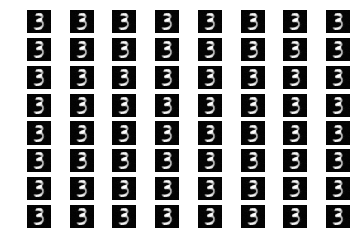

====> Epoch: 91 Average loss: 0.0073
########### generating samples after epoch 91 ###########


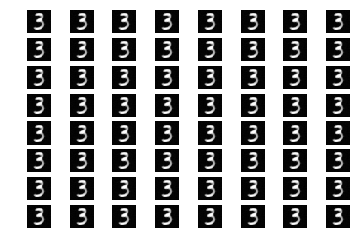

====> Epoch: 92 Average loss: 0.0073
########### generating samples after epoch 92 ###########


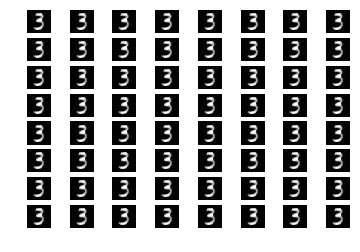

====> Epoch: 93 Average loss: 0.0073
########### generating samples after epoch 93 ###########


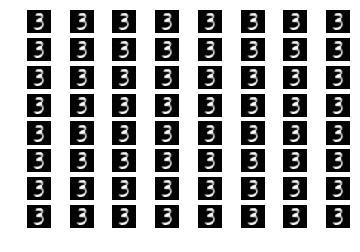

====> Epoch: 94 Average loss: 0.0073
########### generating samples after epoch 94 ###########


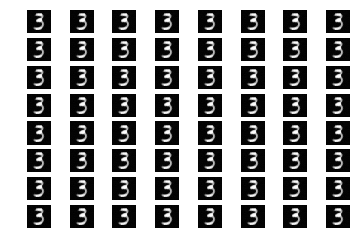

====> Epoch: 95 Average loss: 0.0073
########### generating samples after epoch 95 ###########


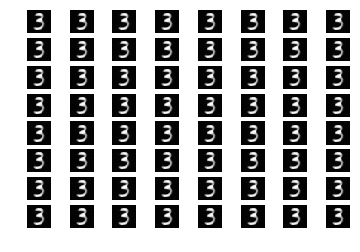

====> Epoch: 96 Average loss: 0.0073
########### generating samples after epoch 96 ###########


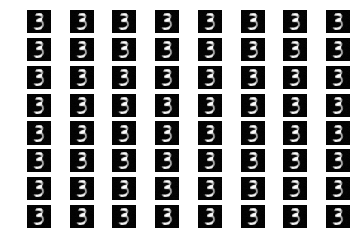

====> Epoch: 97 Average loss: 0.0073
########### generating samples after epoch 97 ###########


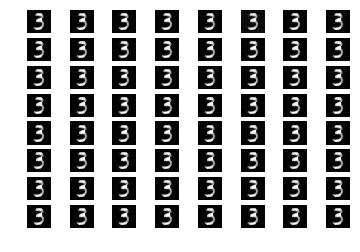

====> Epoch: 98 Average loss: 0.0073
########### generating samples after epoch 98 ###########


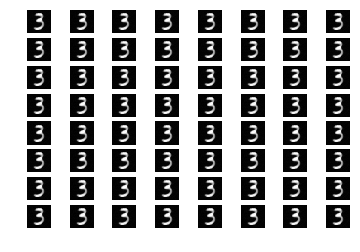

====> Epoch: 99 Average loss: 0.0073
########### generating samples after epoch 99 ###########


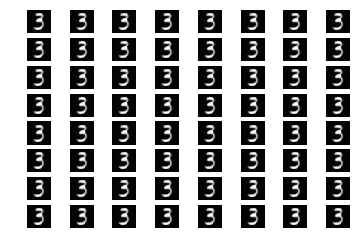

In [15]:
#training
loss_curve = []
for eph in range(n_epoch):
    training_loss = 0
    for itr in range(n_iter):
        #print('dbg1')
        X = next(MNISTd)
        X = Variable(tch.from_numpy(X).cuda())
        #through the encoder
        E.zero_grad()
        #print('X shape: {}'.format(X.size()))
        z_mu, z_log_sig = E(X)
        #print('z_mu shape, z_log_sig shape: {}, {}'.format(z_mu.size(), z_log_sig.size()))
        z = sample_z(z_mu, z_log_sig)
        #print('z shape: {}'.format(z.size()))
        #through the decoder
        z = z.cuda()
        D.zero_grad()
        d_out = D(z)
        #loss
        #recon_loss = F.l1_loss(d_out, X)
        recon_loss = my_L1_eps_loss(d_out, X, 0.3, 0.8)
        KL_div = tch.mean(0.5 * tch.sum(tch.exp(z_log_sig) + z_mu**2 - 1. - z_log_sig, 1))
        KL_div /= BATCHSZ*28*28 # <- learnt a lesson, constansdo matter, kind of like units
        loss = recon_loss + KL_div
        training_loss += loss

        loss.backward()
        optim.step()

        #print results sometimes
#        if itr%10 == 0:
#             print('randomly chosen 64 reconstruted samples after epoch: {}, itr: {}'.format(eph,itr))
#             d = d_out.data.cpu().numpy()
#             d = d.reshape(-1,1,28,28)
#             d1 = list(d)
#             d1 = random.sample(d1, 64)
#             d = np.array(d1)
#             plotter(d)
    print('====> Epoch: {} Average loss: {:.4f}'.format(eph, training_loss.data.cpu().numpy()[0]/n_iter))
    loss_curve.append(training_loss.data.cpu().numpy()[0]/n_iter)
    #generation after this epoch
    print('########### generating samples after epoch {} ###########'.format(eph))
    z_test = tch.randn(n_generated_samples,d_inp_dim)
    z_test = Variable(z_test.view(-1, d_inp_dim).double().cuda())
    #print('ztest shape: {}'.format(z_test.size()))
    y = D(z_test)
    #print('y size: {}'.format(y.size()))
    y = y.data.cpu().numpy().reshape(-1,1,28,28)
    y1 = list(y)
    y1 = random.sample(y1, 64)
    y = np.array(y1)
    plotter(y)
    #to save the model after this epoch (path w.r.t to server)
    #tch.save(E.state_dict(), './models/E_epoch{}.pth'.format(eph))
    #tch.save(D.state_dict(), './models/D_epoch{}.pth'.format(eph))
    

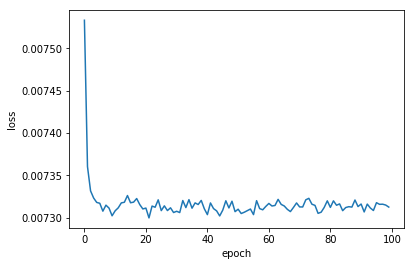

In [16]:
plt.plot(loss_curve)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()